In [8]:
G_save = '/Volumes/GoogleDrive/My Drive/DataSources/SkinCare/Saved/'

In [12]:
df_test = pd.DataFrame(dir(pd))

pickle.dump(df_test, open(G_save + 'df_test', 'wb'))

In [13]:
df_test2 = pickle.load(open(G_save + 'df_test' , 'rb') )

In [9]:
import os
os.listdir(G_save)

['CNN_60x45_Best_Grid_14.06',
 'CNN_60x45_Best_CV_14.06',
 'CNN_Grid_Searc_Details_14_Jun_2022_21:27.csv',
 'Grid_Details14_Jun_2022_21:27',
 'CNN_60x45_Best_Grid14_Jun_2022_21:32',
 'CNN_60x45_Best_CV_14.0614_Jun_2022_21:32',
 'CNNs_Network_Training']

In [15]:
Grid_Details = pickle.load(open(G_save + 'Grid_Details14_Jun_2022_21:27' , 'rb') )

AttributeError: Can't get attribute 'CNN_Net3' on <module '__main__'>

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchvision.transforms.Compose
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
import time
from statistics import mean
import pandas as pd
import sklearn as sk
import pickle
import dill
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
path = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Data/Pickle_Data/'
p_models = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Models/Saved/'
#device = torch.device("cpu")

In [13]:
file = 'DataSource_60x45_blc.pickle' 
data = pd.read_pickle(path + file)

train_data = data[data.type=='train']
valid_data = data[data.type=='valid']
test_data = data[data.type=='test']

training_data = pd.concat([train_data,valid_data], axis=0)
print('Train size: ',train_data.shape[0] ,' Valid Size: ',valid_data.shape[0], ' Test size: ', test_data.shape[0])

Train size:  3450  Valid Size:  609  Test size:  451


# **Standardize Train and Validation data**

In [14]:
training_arrays = np.stack(training_data['img_array'].values)  
training_arrays_scaled = training_arrays / 255
Mean = training_arrays_scaled.mean(axis = (0,1,2)) 
STD = training_arrays_scaled.std(axis = (0,1,2))
print(f"Mean : {Mean}   STD: {STD}") 

Mean : [0.73868471 0.55427031 0.58102355]   STD: [0.13988726 0.14805723 0.16430182]


In [15]:
#Train data standardization
train_arrays_std = np.stack(train_data['img_array'].values) / 255
for i in range(0,train_arrays_std.shape[0]):
    train_arrays_std[i] = (train_arrays_std[i] - Mean) / STD
#Validation data standardization
valid_arrays_std = np.stack(valid_data['img_array'].values) / 255
for i in range(0,valid_arrays_std.shape[0]):
    valid_arrays_std[i] = (valid_arrays_std[i] - Mean) / STD
#Test data standardization
test_arrays_std = np.stack(test_data['img_array'].values) / 255
for i in range(0,test_arrays_std.shape[0]):
    test_arrays_std[i] = (test_arrays_std[i] - Mean) / STD

In [16]:
Mean_t = train_arrays_std.mean(axis = (0,1,2)) 
STD_t = train_arrays_std.std(axis = (0,1,2))
print(f"Mean : {Mean_t}   STD: {STD_t}") 

Mean : [ 0.00141823 -0.00325004 -0.00244724]   STD: [1.00277128 1.00234299 1.0038413 ]


In [17]:
train_arrays_std_T = torch.tensor(train_arrays_std, dtype= torch.float32).transpose(3,1)
train_labels = torch.tensor(train_data['label_id'].values.astype(np.long))

valid_arrays_std_T = torch.tensor(valid_arrays_std, dtype= torch.float32).transpose(3,1)
valid_labels = torch.tensor(valid_data['label_id'].values.astype(np.long))

test_arrays_std_T = torch.tensor(test_arrays_std, dtype= torch.float32).transpose(3,1)
test_labels = torch.tensor(test_data['label_id'].values.astype(np.long))

input_data = (train_arrays_std_T , valid_arrays_std_T, test_arrays_std_T , torch.cat((train_arrays_std_T,valid_arrays_std_T,test_arrays_std_T),0) )
labels = (train_labels,valid_labels,test_labels , torch.cat((train_labels,valid_labels,test_labels),0))

### **1.2 Nets**

In [18]:
class CNN_Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
        self.conv2 = nn.Conv2d( in_channels=32, out_channels=32 , kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
        self.conv4 = nn.Conv2d( in_channels=64, out_channels=64 , kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.fc1   = nn.Linear(in_features= 6144 , out_features = 512)
        self.fc2   = nn.Linear(in_features= 512, out_features = 7)
        self.Act   = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.Act(self.conv1(x))
        out = self.Act(self.conv2(out))
        out = self.Act(self.pool1(out))
        out = self.Act(self.conv3(out))
        out = self.Act(self.conv4(out))
        out = self.Act(self.pool2(out))
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.Act(self.fc2(out))
        # out = nn.Softmax(out)
        return out
        
class CNN_Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
        # self.conv2 = nn.Conv2d( in_channels=32, out_channels=32 , kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
        # self.conv4 = nn.Conv2d( in_channels=64, out_channels=64 , kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.fc1   = nn.Linear(in_features= 7488 , out_features = 512)
        self.fc2   = nn.Linear(in_features= 512, out_features = 7)
        self.Act   = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.Act(self.conv1(x))
        # out = self.Act(self.conv2(out))
        out = self.Act(self.pool1(out))
        out = self.Act(self.conv3(out))
        # out = self.Act(self.conv4(out))
        out = self.Act(self.pool2(out))
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.Act(self.fc2(out))
        # out = nn.Softmax(out)
        return out

class CNN_Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
        # self.conv2 = nn.Conv2d( in_channels=32, out_channels=32 , kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
        # self.conv4 = nn.Conv2d( in_channels=64, out_channels=64 , kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.fc1   = nn.Linear(in_features= 7488 , out_features = 512)
        self.fc2   = nn.Linear(in_features= 512, out_features = 7)
        self.Act   = nn.ReLU(inplace=True)
        self.Act_S   = nn.Sigmoid()
    def forward(self, x):
        out = self.Act(self.conv1(x))
        # out = self.Act(self.conv2(out))
        out = self.Act(self.pool1(out))
        out = self.Act(self.conv3(out))
        # out = self.Act(self.conv4(out))
        out = self.Act(self.pool2(out))
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.Act_S(self.fc2(out))
        # out = nn.Softmax(out)
        return out

# **Confusion-Matrix & Accuracy**

In [19]:
def confusion_matrix(Y_pred,Y):
    CM = sk.metrics.confusion_matrix(Y_pred,Y)
    Total_sum = sum(sum(CM))
    Diagonal_sum = np.trace(CM) 
    accuracy1 = Diagonal_sum / Total_sum
    frequencies = list(pd.DataFrame(Y).value_counts())
    weights = list(np.divide(frequencies, Total_sum))
    sensitivity = []
    specificity = []
    for i in range(0,7):
        sensitivity_ = CM[i,i].sum() / (CM[i].sum())
        sensitivity.append(sensitivity_)
        specificity_ = (Diagonal_sum - CM[i,i]) / (  (Diagonal_sum - CM[i,i]) + (CM.T[i].sum()-CM[i,i]))
        specificity.append(specificity_)
        
    print('Nr. of Data : \n', Total_sum)
    print('Accuracy of The Model : \n', accuracy1)
    print('Confusion Matrix : \n', CM)
    print('Weighted Avg. of sensitivity : \n', np.average(np.nan_to_num(sensitivity), weights=weights))
    print('Weighted Avg. of specificity : \n', np.average(np.nan_to_num(specificity), weights=weights))
    sk.metrics.ConfusionMatrixDisplay(CM).plot()

# **Model 1: 60x45 - with Duplications**

In [20]:
CNN_Net1,CNN_Net2,CNN_Net3, Model_Training = dill.load( open(p_models + 'CNNs_Network_Training', 'rb'))

In [21]:
Model_1 = pickle.load(open(p_models + 'CNN_60x45_Duplicated' , 'rb') )

Nr. of Data : 
 451
Accuracy of The Model : 
 0.6008869179600886
Confusion Matrix : 
 [[18  6  3  1  5  3  0]
 [ 5 25  6  5  3  0  4]
 [ 1 14 77  1 26  9  0]
 [ 1  0  0  0  0  0  0]
 [ 3  2 20  0 41  5  1]
 [ 4  3 15  1 27 98  3]
 [ 0  1  1  0  1  0 12]]
Weighted Avg. of sensitivity : 
 0.4888228946915448
Weighted Avg. of specificity : 
 0.8956341098856812


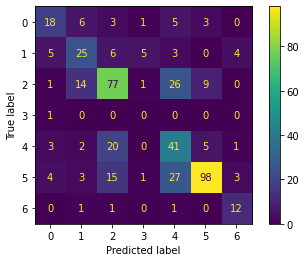

In [11]:
model_ = Model_1.model.eval()
X = input_data[2]
Y = labels[2]
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y_pred,Y)

Nr. of Data : 
 451
Accuracy of The Model : 
 0.6008869179600886
Confusion Matrix : 
 [[18  6  3  1  5  3  0]
 [ 5 25  6  5  3  0  4]
 [ 1 14 77  1 26  9  0]
 [ 1  0  0  0  0  0  0]
 [ 3  2 20  0 41  5  1]
 [ 4  3 15  1 27 98  3]
 [ 0  1  1  0  1  0 12]]
Weighted Avg. of sensitivity : 
 0.4888228946915448
Weighted Avg. of specificity : 
 0.8956341098856812


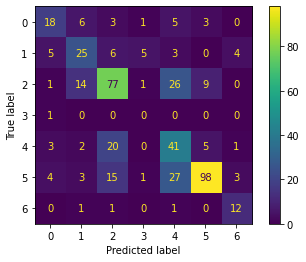

In [22]:
model_ = Model_1.model.eval()
X = input_data[2]
Y = labels[2]
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y_pred,Y)

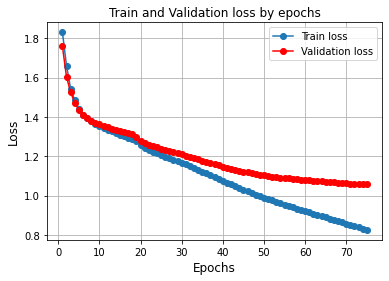

In [23]:
model_ = Model_1
epochs_X = [i for i in range(1, model_.epochs+1)]
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_loss, 'o-', label='Train loss')
plt.plot(epochs_X , model_.Epochs_Val_loss,'ro-', label='Validation loss')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation loss by epochs')
plt.show()

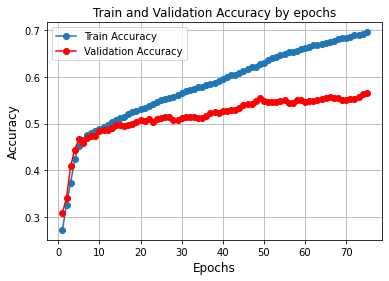

In [13]:
model_ = Model_1
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_Acc, 'o-', label='Train Accuracy')
plt.plot(epochs_X , model_.Epochs_Val_Acc,'ro-', label='Validation Accuracy')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation Accuracy by epochs')
plt.show()

# **Adding CNN output to DataSource**

In [14]:
datasource = pd.concat([train_data,valid_data, test_data], axis=0).reset_index(drop=True)

In [15]:
#Train data standardization
datasource_std = np.stack(datasource['img_array'].values) / 255
for i in range(0,datasource_std.shape[0]):
    datasource_std[i] = (datasource_std[i] - Mean) / STD

datasource_std_T = torch.tensor(datasource_std, dtype= torch.float32).transpose(3,1)



In [22]:
model_ = Model_1.model.eval()
datasource_CNN_out = model_(datasource_std_T)
datasource_CNN_soft = torch.softmax(datasource_CNN_out,dim=1)
df_CNN = pd.DataFrame(datasource_CNN_soft.detach().numpy()).add_prefix('CNN_')
datasource_v2 = pd.concat([datasource,df_CNN],axis=1).reset_index(drop=True)

In [23]:
datasource_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510 entries, 0 to 4509
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   image_id      4510 non-null   object  
 1   img_array     4510 non-null   object  
 2   lesion_id     4510 non-null   object  
 3   image_label   4510 non-null   category
 4   dx_type       4510 non-null   object  
 5   age           4510 non-null   float64 
 6   sex           4510 non-null   object  
 7   localization  4510 non-null   object  
 8   label_id      4510 non-null   int8    
 9   type          4510 non-null   object  
 10  CNN_0         4510 non-null   float32 
 11  CNN_1         4510 non-null   float32 
 12  CNN_2         4510 non-null   float32 
 13  CNN_3         4510 non-null   float32 
 14  CNN_4         4510 non-null   float32 
 15  CNN_5         4510 non-null   float32 
 16  CNN_6         4510 non-null   float32 
dtypes: category(1), float32(7), float64(1), int8(1), obj

**Check Null Values**

In [24]:
datasource_v2.isnull().any()

image_id        False
img_array       False
lesion_id       False
image_label     False
dx_type         False
age             False
sex             False
localization    False
label_id        False
type            False
CNN_0           False
CNN_1           False
CNN_2           False
CNN_3           False
CNN_4           False
CNN_5           False
CNN_6           False
dtype: bool

In [25]:
datasource_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510 entries, 0 to 4509
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   image_id      4510 non-null   object  
 1   img_array     4510 non-null   object  
 2   lesion_id     4510 non-null   object  
 3   image_label   4510 non-null   category
 4   dx_type       4510 non-null   object  
 5   age           4510 non-null   float64 
 6   sex           4510 non-null   object  
 7   localization  4510 non-null   object  
 8   label_id      4510 non-null   int8    
 9   type          4510 non-null   object  
 10  CNN_0         4510 non-null   float32 
 11  CNN_1         4510 non-null   float32 
 12  CNN_2         4510 non-null   float32 
 13  CNN_3         4510 non-null   float32 
 14  CNN_4         4510 non-null   float32 
 15  CNN_5         4510 non-null   float32 
 16  CNN_6         4510 non-null   float32 
dtypes: category(1), float32(7), float64(1), int8(1), obj

**One-Hot Encoding**

In [26]:
cols = ['localization','sex','dx_type']
datasource_v2_OneHot = pd.get_dummies(datasource_v2, columns= cols).reset_index(drop=True)

In [27]:
datasource_v2_OneHot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510 entries, 0 to 4509
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   image_id                      4510 non-null   object  
 1   img_array                     4510 non-null   object  
 2   lesion_id                     4510 non-null   object  
 3   image_label                   4510 non-null   category
 4   age                           4510 non-null   float64 
 5   label_id                      4510 non-null   int8    
 6   type                          4510 non-null   object  
 7   CNN_0                         4510 non-null   float32 
 8   CNN_1                         4510 non-null   float32 
 9   CNN_2                         4510 non-null   float32 
 10  CNN_3                         4510 non-null   float32 
 11  CNN_4                         4510 non-null   float32 
 12  CNN_5                         4510 non-null   fl

In [28]:
pd.to_pickle(datasource_v2_OneHot, path+'DataSource_60x45_OneHot_CNN.pickle')

In [ ]:
datasource_v2_OneHot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510 entries, 0 to 4509
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   image_id                      4510 non-null   object  
 1   img_array                     4510 non-null   object  
 2   lesion_id                     4510 non-null   object  
 3   image_label                   4510 non-null   category
 4   age                           4510 non-null   float64 
 5   label_id                      4510 non-null   int8    
 6   type                          4510 non-null   object  
 7   CNN_0                         4510 non-null   float32 
 8   CNN_1                         4510 non-null   float32 
 9   CNN_2                         4510 non-null   float32 
 10  CNN_3                         4510 non-null   float32 
 11  CNN_4                         4510 non-null   float32 
 12  CNN_5                         4510 non-null   fl

**Ordinal Encoding**

In [31]:
ord_enc = sk.preprocessing.OrdinalEncoder()
datasource_v3_Ord = datasource_v2
datasource_v3_Ord['sex'] = ord_enc.fit_transform(datasource_v3_Ord[['sex']])
datasource_v3_Ord['localization'] = ord_enc.fit_transform(datasource_v3_Ord[['localization']])
datasource_v3_Ord['dx_type'] = ord_enc.fit_transform(datasource_v3_Ord[['dx_type']])
datasource_v3_Ord.reset_index(drop=True, inplace=True)

In [29]:
def MinMaxScaling(dataset, attr):
    min = dataset[dataset.type.str.contains('train|valid')][attr].min()
    max = dataset[dataset.type.str.contains('train|valid')][attr].max()
    dataset[attr] = (dataset[attr] - min ) / (max-min)
    return dataset

In [36]:
datasource_v3_Ord_Norm = datasource_v3_Ord.copy()
datasource_v3_Ord_Norm = MinMaxScaling(datasource_v3_Ord_Norm , 'localization')
datasource_v3_Ord_Norm = MinMaxScaling(datasource_v3_Ord_Norm , 'dx_type')

In [39]:
datasource_v3_Ord_Norm.localization.value_counts()

0.083333    999
0.666667    862
0.333333    731
1.000000    587
0.916667    403
0.000000    309
0.166667    246
0.750000    104
0.833333     93
0.416667     92
0.583333     42
0.250000     33
0.500000      9
Name: localization, dtype: int64

In [ ]:
pd.to_pickle(datasource_v3_Ord, path+'DataSource_60x45_Ordinal_CNN.pickle' )